In [1]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(2)]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

In [3]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 5e-4, BATCH_SIZE: int = 64, LATENT_DIM: int = 128):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.RMSprop(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self = self.to('cuda')
        var_x, var_y = 0, 0
        noise = torch.randn(size=(BATCH_SIZE, LATENT_DIM)).cuda()

        while var_x < .1 or var_y < .1:
            output = self.layers(noise).detach().cpu().numpy()
            var_x = np.var(output[:, 0])
            var_y = np.var(output[:, 1])
        
            for layer in self.modules():
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
        print(f'{var_x=}, {var_y=}')

In [4]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.SGD(self.parameters(), lr)
        self.loss = nn.BCEWithLogitsLoss()
        self = self.to('cuda')

    def training_step(self, true_data, fake_data, steps):
        for _ in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_data)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_true).cuda())
            
            loss = loss_true + loss_fake
            loss.backward()
            self.optim.step()
        
        return loss.detach()

x_greisen_random.size=16000, x.size=16000
np.sum(counts_greisen)=np.float64(16000.0)
np.sum(counts_GAN)=np.float64(16000.0)
np.sum(bins_greisen)=np.float64(683.5799785175338)
np.sum(bins_GAN)=np.float64(943.9783395528793)


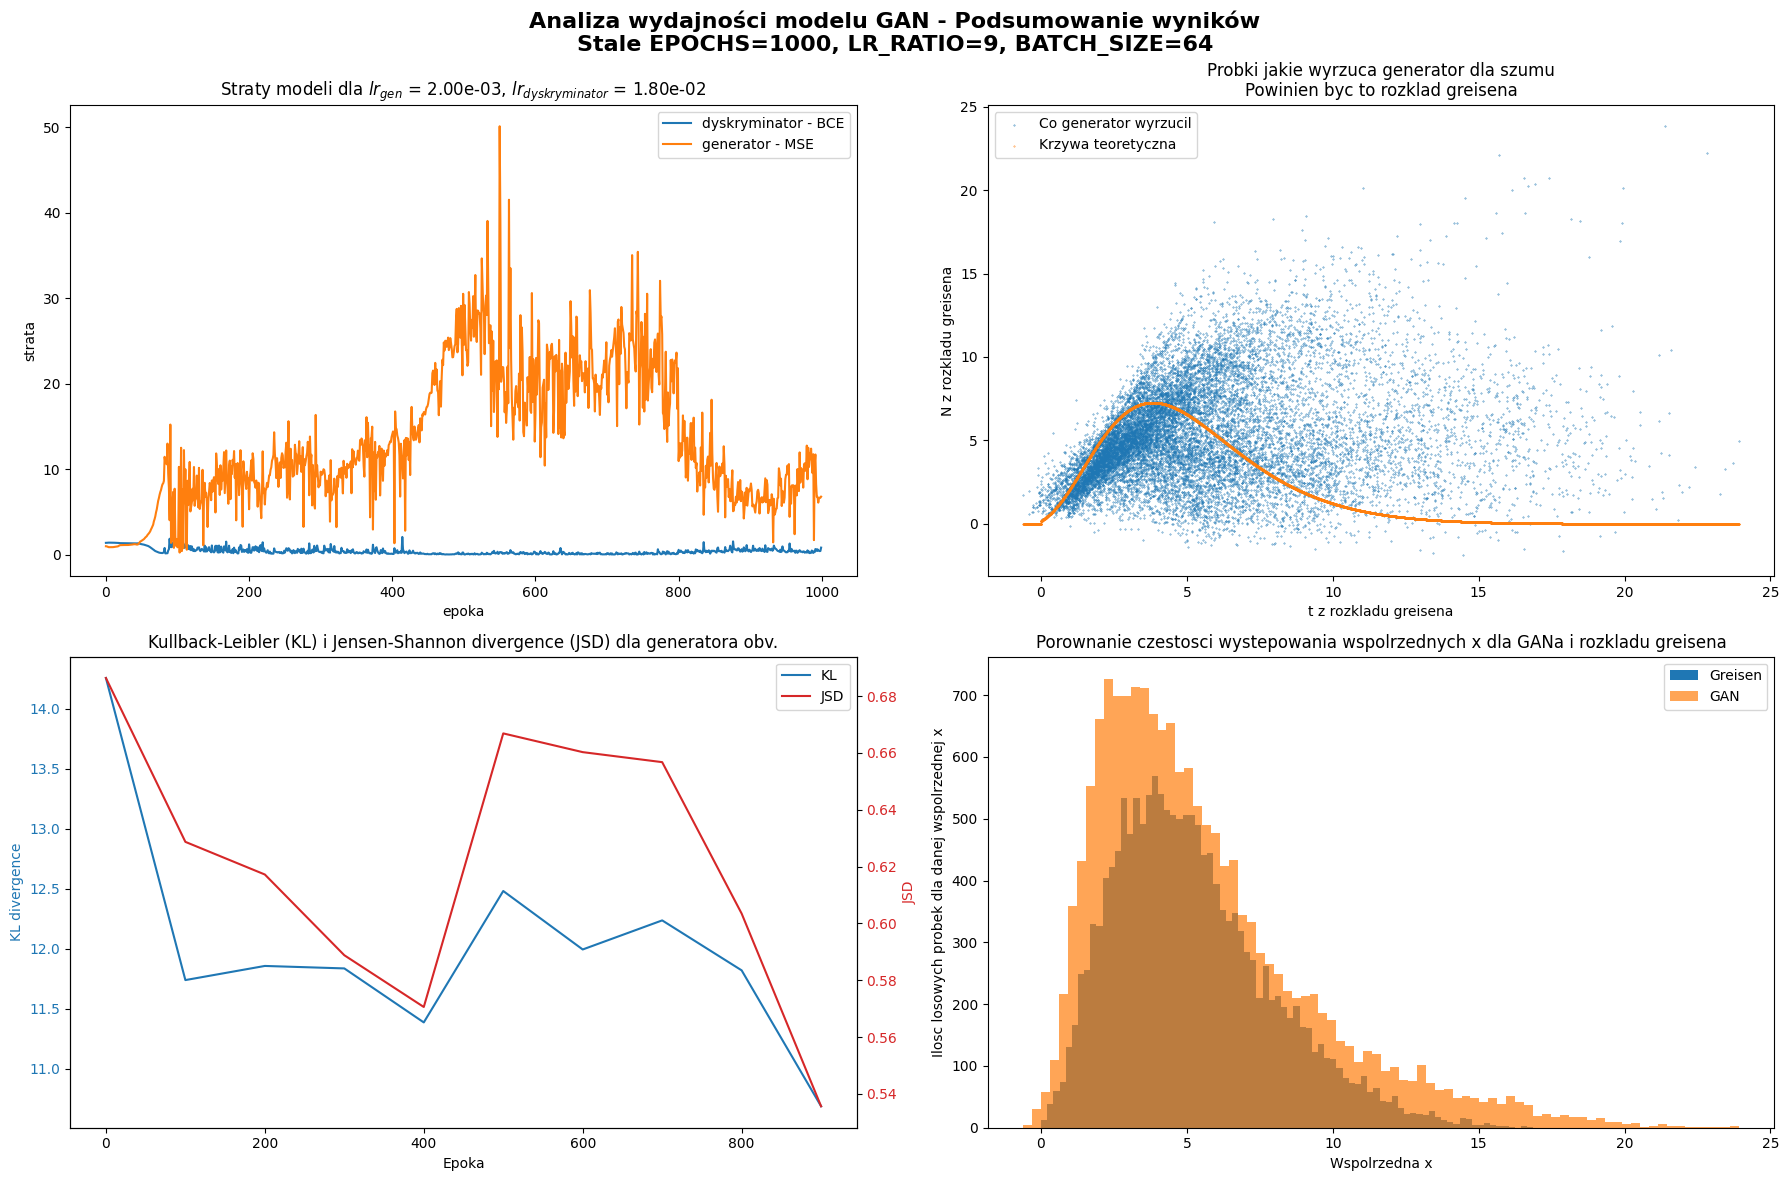

In [ ]:
def plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, EPOCHS_TO_SAVE_KL_JSD):
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Wykres 1: Straty
    ax1.set_title(rf'Straty modeli dla $lr_{{gen}}$ = {generator.optim.param_groups[0]["lr"]:.2e}, $lr_{{dyskryminator}}$ = {discriminator.optim.param_groups[0]["lr"]:.2e}')
    ax1.plot(discriminator_losses, label='dyskryminator - BCE')
    ax1.plot(generator_losses, label='generator - MSE')
    ax1.legend()
    ax1.set_xlabel('epoka')
    ax1.set_ylabel('strata')
    
    # Wykres 2: Próbki generatora
    noise = torch.randn(size=(1_000, 128)).cuda()
    output = generator.layers(noise).cpu().detach().numpy().reshape(-1, 2)
    x, y = output[:, 0], output[:, 1]
    x_krzywa = np.linspace(np.min(x), np.max(x), num=output.shape[0])
    y_krzywa = greisen(x_krzywa)
    ax2.set_title('Probki jakie wyrzuca generator dla szumu\nPowinien byc to rozklad greisena')
    ax2.scatter(x, y, s=0.1, label='Co generator wyrzucil')
    ax2.scatter(x_krzywa, y_krzywa, s=0.1, label='Krzywa teoretyczna')
    ax2.legend()
    ax2.set_xlabel('t z rozkladu greisena')
    ax2.set_ylabel('N z rozkladu greisena')
    
    # Wykres 3: KL i JSD
    ax3.set_title('Kullback-Leibler (KL) i Jensen-Shannon divergence (JSD) dla generatora obv.')
    ax3.set_xlabel('Epoka')
    # os dla KL
    color1 = 'tab:blue'
    ax3.set_ylabel('KL divergence', color=color1)
    line1 = ax3.plot(np.arange(KL.size) * EPOCHS_TO_SAVE_KL_JSD, KL,
                    color=color1, label='KL')
    ax3.tick_params(axis='y', labelcolor=color1)
    # Druga oś dla JSD
    ax3_twin = ax3.twinx()
    color2 = 'tab:red'
    ax3_twin.set_ylabel('JSD', color=color2)
    line2 = ax3_twin.plot(np.arange(JSD.size) * EPOCHS_TO_SAVE_KL_JSD, JSD,
                        color=color2, label='JSD')
    ax3_twin.tick_params(axis='y', labelcolor=color2)
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Wykres 4: czestosci
    x_greisen_random, *_ = metropolis_hastings_probing(greisen, x.size)
    print(f'{x_greisen_random.size=}, {x.size=}')
    ax4.set_title('Porownanie czestosci wystepowania wspolrzednych x dla GANa i rozkladu greisena')
    counts_greisen, bins_greisen, patches_greisen = ax4.hist(x_greisen_random, bins=80, label='Greisen')
    counts_GAN, bins_GAN, patches_GAN = ax4.hist(x, bins=80, label='GAN', alpha=0.7)
    
    print(f'{np.sum(counts_greisen)=}')
    print(f'{np.sum(counts_GAN)=}')
    print(f'{np.sum(bins_greisen)=}')
    print(f'{np.sum(bins_GAN)=}')
    
    ax4.legend()
    ax4.set_xlabel('Wspolrzedna x')
    ax4.set_ylabel('Ilosc losowych probek dla danej wspolrzednej x')
    
    # GŁÓWNY TYTUŁ DLA WSZYSTKICH WYKRESÓW
    plt.suptitle(f'Analiza wydajności modelu GAN - Podsumowanie wyników\nStale {EPOCHS=}, {LR_RATIO=}, {BATCH_SIZE=}', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig('./Wykresy/GAN/podsumowanie.jpg') 

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, EPOCHS_TO_SAVE_KL_JSD)

var_x=np.float32(0.10357401), var_y=np.float32(0.102910876)
epoch=0
epoch=100
epoch=200
epoch=300
epoch=400
epoch=500
epoch=600
epoch=700
epoch=800
epoch=900
x_greisen_random.size=16000, x.size=16000


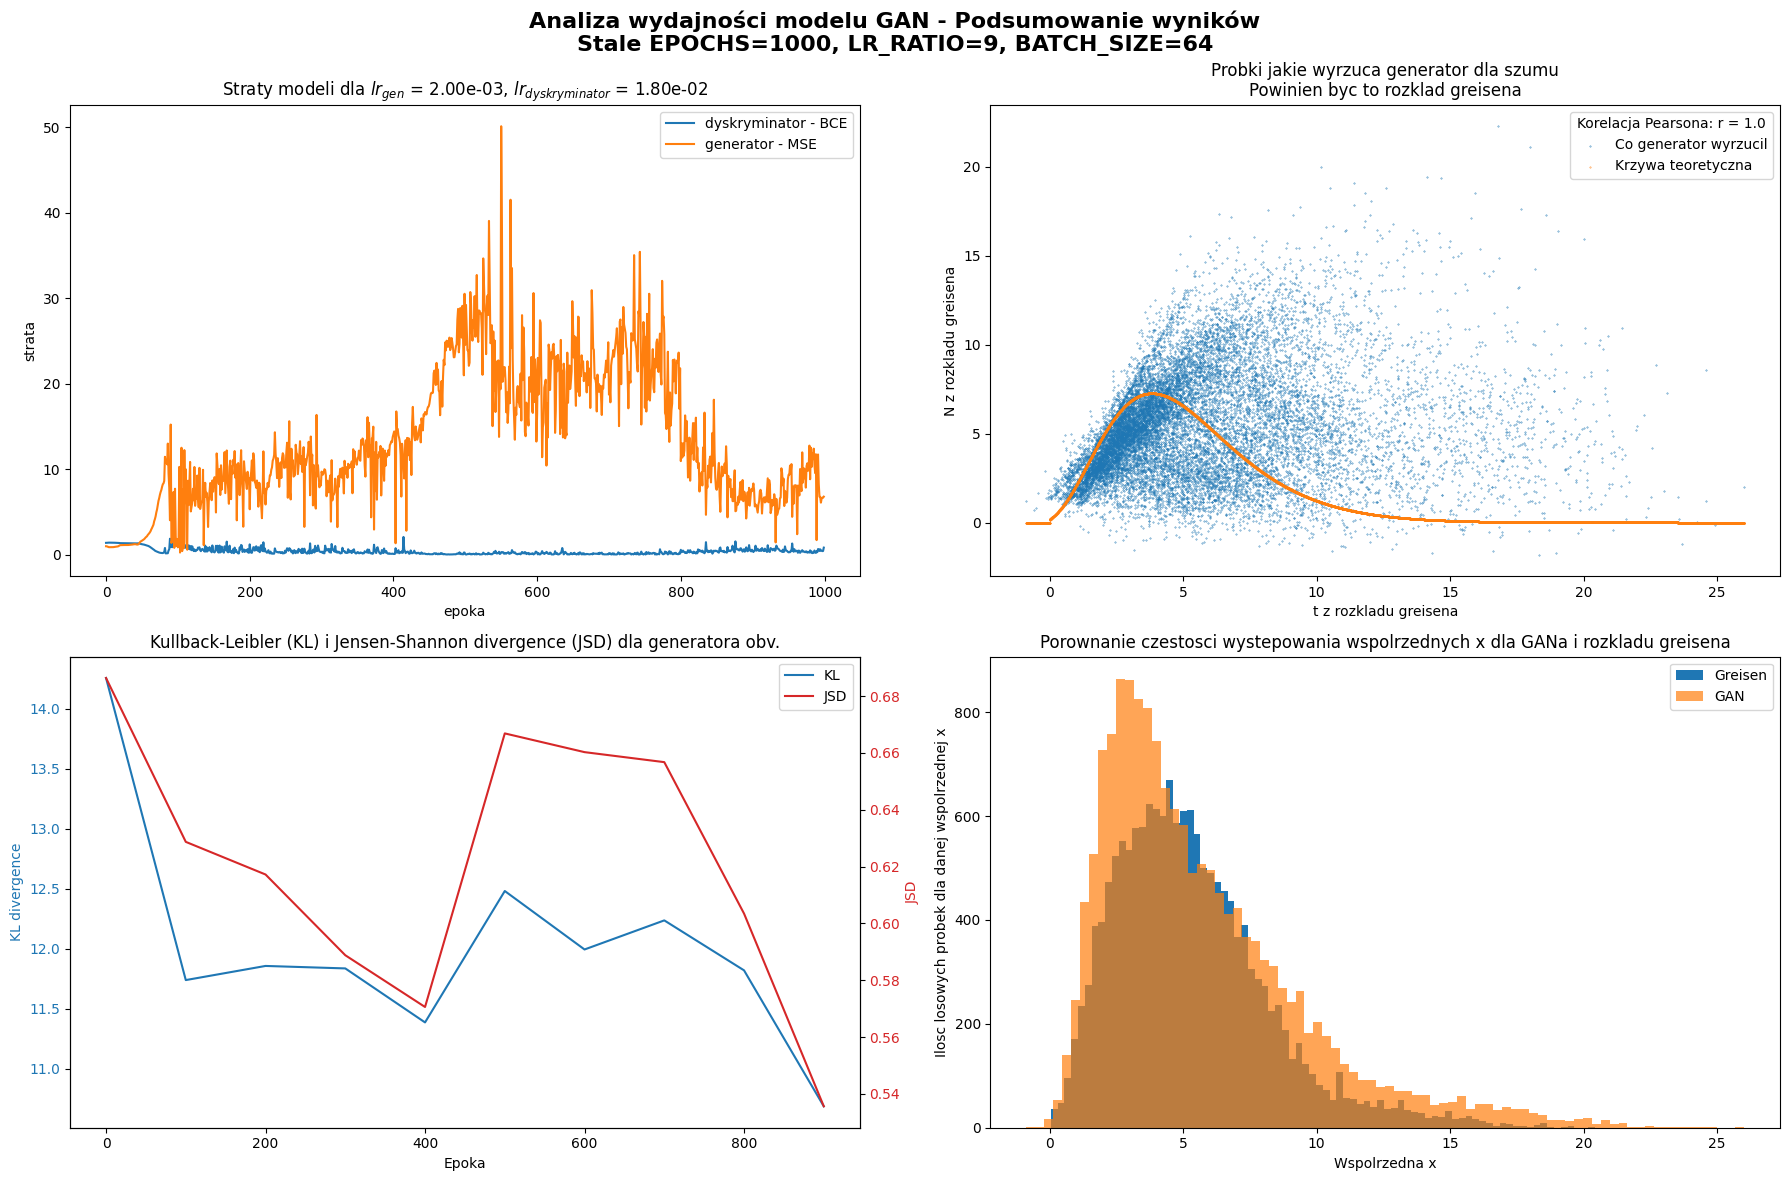

In [17]:
# Konfiguracja
EPOCHS = 1_000
LR_RATIO = 9 # LR_DYSKR / LR_GEN
BATCH_SIZE = 64
LATENT_DIM = 128
EPOCHS_TO_SAVE_KL_JSD = 100
GENERATOR_SAMPLES_TO_RETURN = 16 # dla 1 na pewno dziala w miare gut

generator_losses, discriminator_losses = np.zeros(EPOCHS), np.zeros(EPOCHS)
KL, JSD = np.zeros(EPOCHS // 100), np.zeros(EPOCHS // 100)

generator_layers = [ # bez konwolucji poki co, potem sie doda batchNorm i funkcje aktywacji
    nn.Linear(LATENT_DIM, 64),  nn.ReLU(),
    nn.Linear(64, 32),          nn.ReLU(),
    nn.Linear(32, 16),          nn.ReLU(),
    nn.Linear(16, 8),           nn.ReLU(),
    nn.Linear(8, 4),            nn.ReLU(),
    nn.Linear(4, 2 * GENERATOR_SAMPLES_TO_RETURN),
    # nn.ReLU() # to ReLU chyba znieksztalca rozklad ze dla malych x - ale bez niego nawet nauczony dyskryminator zwraca wyniki nie fizyczne
]
generator = Generator(generator_layers, 1e-3 / EPOCHS * 2_000, BATCH_SIZE, LATENT_DIM) #! Na e-4 juz sa za male lr-y nieco, dodaj lr schedulera moze szczegolnie na koniec

discriminator_layers = [ #! Nie dodawaj sigmoida to sie nie sprawdza
    nn.Linear(2 * GENERATOR_SAMPLES_TO_RETURN, 64), nn.LeakyReLU(0.2),
    nn.Linear(64, 32),  nn.LeakyReLU(0.2),
    nn.Linear(32, 16),  nn.LeakyReLU(0.2),
    nn.Linear(16, 8),   nn.LeakyReLU(0.2),
    nn.Linear(8, 2),    nn.LeakyReLU(0.2),
    nn.Linear(2, 1)
]
discriminator = Discriminator(discriminator_layers, 1e-3 * LR_RATIO / EPOCHS * 2_000)

generator.train()
discriminator.train()

epoch = 0
while epoch < EPOCHS:
    # Dane
    noise = torch.randn(BATCH_SIZE, LATENT_DIM).cuda()
    fake_data = generator.layers(noise).detach()
    fake_np = fake_data.cpu().numpy()
    
    xs, ys = metropolis_hastings_probing(greisen, length=BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
    true_data = torch.FloatTensor(np.vstack([xs, ys]).T).cuda().reshape(fake_data.shape)

    # Trening
    discriminator_losses[epoch] = discriminator.training_step(true_data, fake_data, 5).item()

    generator.zero_grad()
    fake_data = generator.layers(noise)
    fake_labels = discriminator.layers(fake_data)
    gen_loss = generator.loss(fake_labels, torch.ones_like(fake_labels))
    gen_loss.backward()
    generator.optim.step()
    generator_losses[epoch] = gen_loss.detach().item()

    fake_np = fake_np.reshape(-1, 2) # chce dostac same probki do statystyk x i y
    true_data = true_data.view(-1, 2)
    
    if epoch % EPOCHS_TO_SAVE_KL_JSD == 0:
        print(f'{epoch=}')
        KL[epoch // EPOCHS_TO_SAVE_KL_JSD], JSD[epoch // EPOCHS_TO_SAVE_KL_JSD] = fast_kl_jsd_2d(true_data.cpu().numpy(), fake_np)

    # Mode collapse check
    collapsed_samples = np.sum(np.isclose(fake_np[:, 0], 0.0) | np.isclose(fake_np[:, 1], 0.0))
    if collapsed_samples > int(fake_np[:, 0].size * 0.9): # Jesli 90% poszlo na mode collapse to od nowa
        print(f'Mode collapse - restart {collapsed_samples / fake_np[:, 0].size * 100 :.2f}% particles has collapsed.')

        generator = Generator(generator_layers, 1e-3 / EPOCHS * 2_000, BATCH_SIZE, LATENT_DIM)
        discriminator = Discriminator(discriminator_layers, 1e-3 * LR_RATIO / EPOCHS * 2_000)
        
        plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, EPOCHS_TO_SAVE_KL_JSD)
        epoch = 0
        continue
    
    epoch += 1

generator.eval()
discriminator.eval()

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, EPOCHS_TO_SAVE_KL_JSD)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 6400

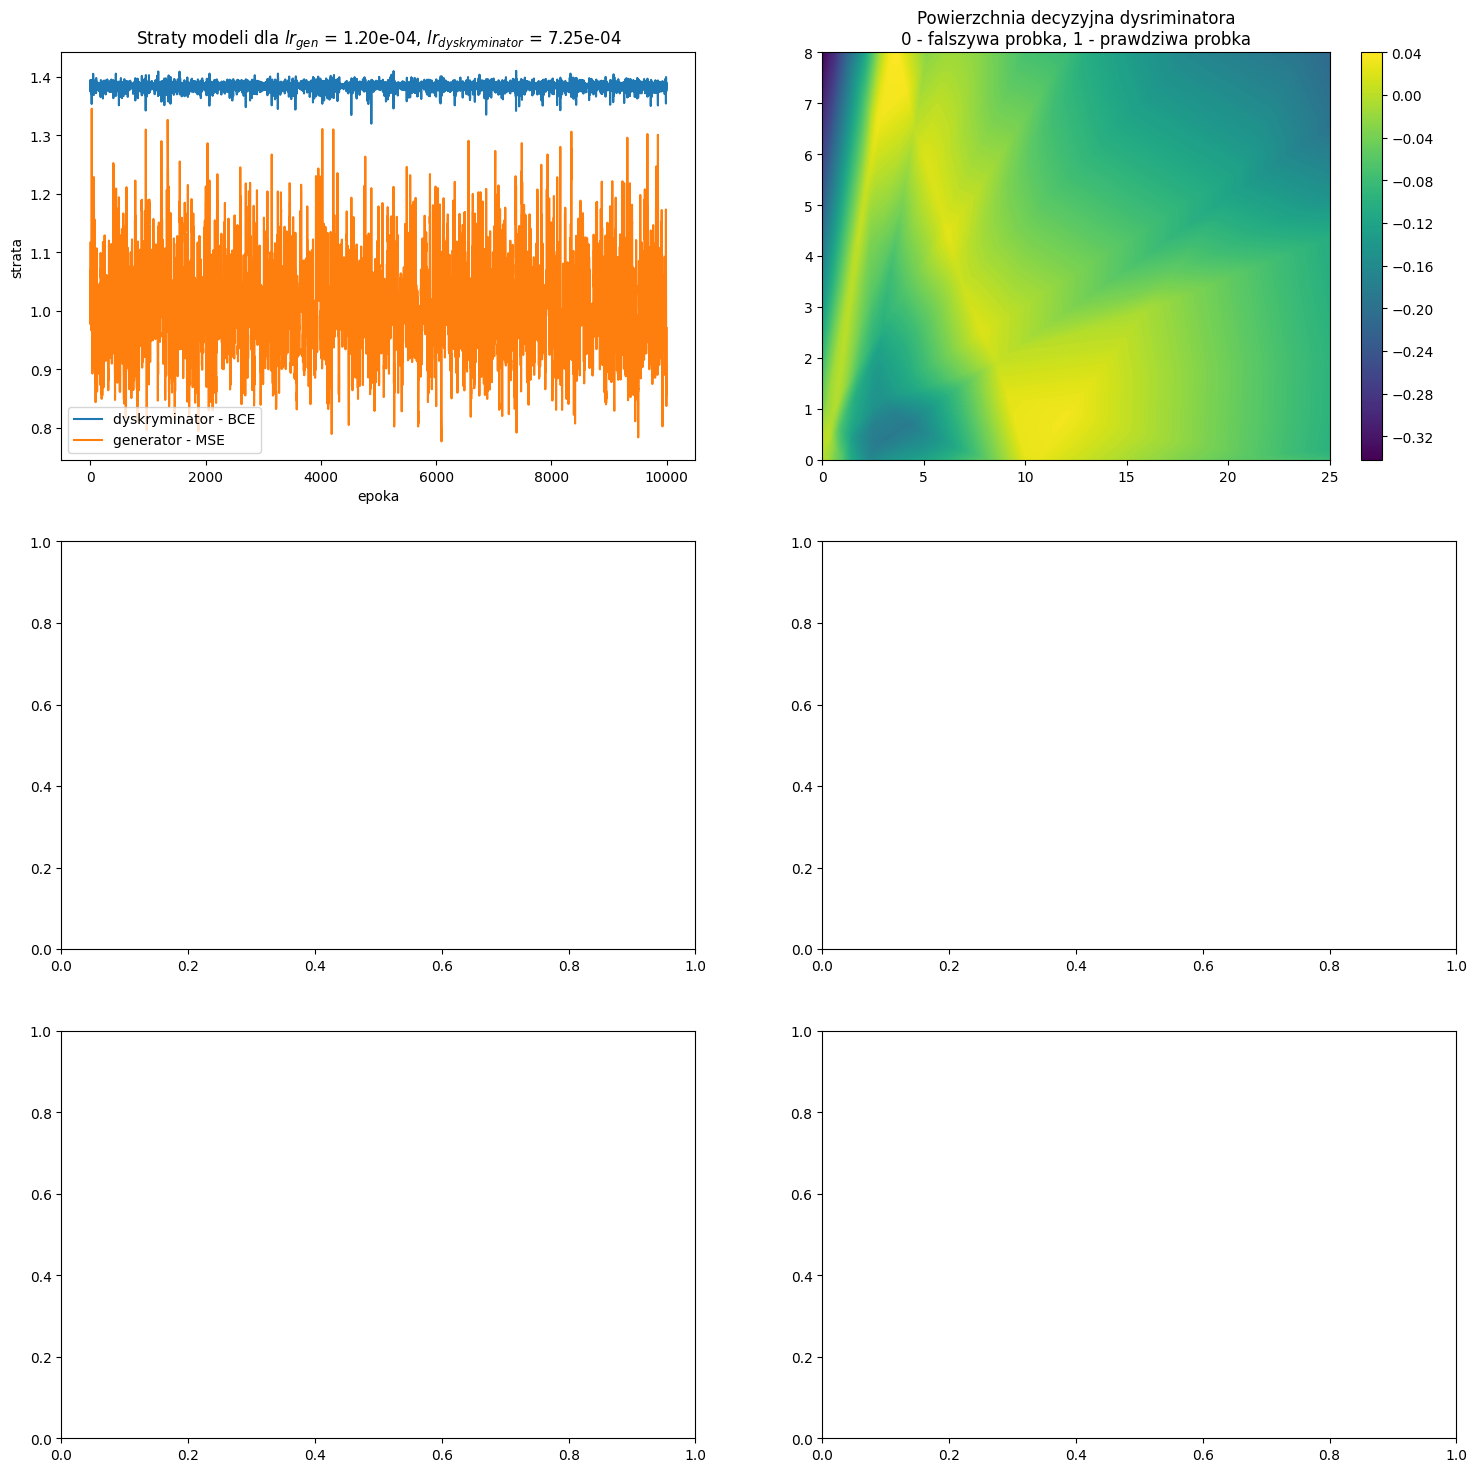

In [ ]:
plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, EPOCHS_TO_SAVE_KL_JSD)

In [36]:
torch.save(discriminator.state_dict(), "best_discriminator_so_far.pth")
torch.save(generator.state_dict(), 'best_generator_so_far.pth')